In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/WORKSPACE/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.610368,0.930810,00:01
1,0.842898,0.679615,00:01
2,0.652379,0.674924,00:01


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [48]:
path=Config.data_path()/'ml-100k'

In [49]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [50]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [51]:
len(ratings)

100000

In [53]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [60]:
rating_movie= rating_movie.rename({'rating':'rate'}, axis=1)

In [61]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [62]:
data.show_batch()

userId,title,target
647,Romy and Michele's High School Reunion (1997),3.0
881,"Man Who Would Be King, The (1975)",5.0
20,Young Frankenstein (1974),2.0
528,King of New York (1990),1.0
749,Arsenic and Old Lace (1944),5.0


In [64]:
y_range = [0,5.5]

In [65]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


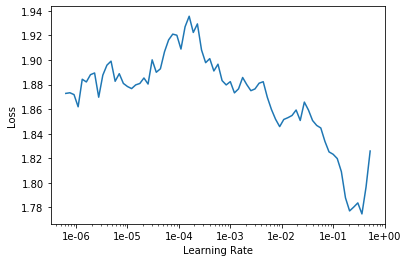

In [66]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [67]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.946910,0.942862,00:06
1,0.856767,0.890409,00:05
2,0.772109,0.836545,00:05
3,0.646213,0.816552,00:05
4,0.557952,0.815946,00:05


In [68]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [69]:
learn.load('dotprod');

In [70]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [72]:
g = rating_movie.groupby(title)['rate'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [74]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [77]:
mean_ratings = rating_movie.groupby(title)['rate'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [78]:
item0 = lambda o:o[0]

In [79]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3257),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2939), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2778),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2725), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2577), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2496), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2438), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2434), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2400), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2393), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2359), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2295), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2191), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2157), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2120), 'Home A

In [80]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6075), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5781), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5779), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5526), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5498), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5339), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5322), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5297), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5259), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.5017), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4969), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4930), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4832), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4743), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4683), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [81]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [84]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [85]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [86]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1690), 'Wrong Trousers, The (1993)'),
 (tensor(1.0551), 'Chinatown (1974)'),
 (tensor(1.0478), 'Lawrence of Arabia (1962)'),
 (tensor(1.0417), 'Casablanca (1942)'),
 (tensor(1.0249), 'When We Were Kings (1996)'),
 (tensor(1.0080), 'Close Shave, A (1995)'),
 (tensor(0.9966),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9809), 'Third Man, The (1949)'),
 (tensor(0.9647), 'Godfather, The (1972)'),
 (tensor(0.9531), 'Shall We Dance? (1996)')]

In [87]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2613), "McHale's Navy (1997)"),
 (tensor(-1.2373), 'Home Alone 3 (1997)'),
 (tensor(-1.2350), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.2307), 'Jungle2Jungle (1997)'),
 (tensor(-1.1636), 'Leave It to Beaver (1997)'),
 (tensor(-1.1519), 'Bio-Dome (1996)'),
 (tensor(-1.1267), 'Flipper (1996)'),
 (tensor(-1.0694), 'Congo (1995)'),
 (tensor(-1.0581), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0450), 'Batman & Robin (1997)')]

In [88]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [89]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9202), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8563), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.8540), 'Trainspotting (1996)'),
 (tensor(0.8362), 'Keys to Tulsa (1997)'),
 (tensor(0.8001), 'Stupids, The (1996)'),
 (tensor(0.7779), 'Dead Man (1995)'),
 (tensor(0.7604), 'Clockwork Orange, A (1971)'),
 (tensor(0.7599), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7084), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7083), 'Crumb (1994)')]

In [90]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1666), 'Braveheart (1995)'),
 (tensor(-1.0701), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9793), 'Titanic (1997)'),
 (tensor(-0.9565), "It's a Wonderful Life (1946)"),
 (tensor(-0.8737), 'American President, The (1995)'),
 (tensor(-0.8532), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8364), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8350), 'Pretty Woman (1990)'),
 (tensor(-0.8257), 'Affair to Remember, An (1957)'),
 (tensor(-0.8209), "Mr. Holland's Opus (1995)")]

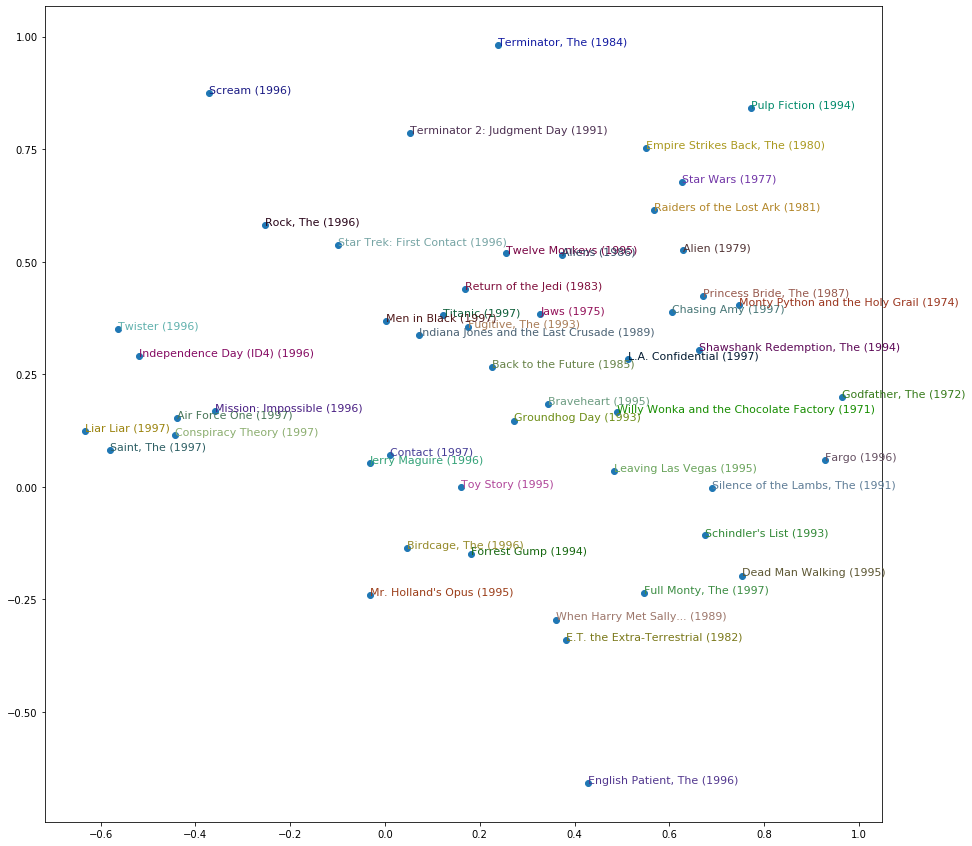

In [91]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()